## Experimenting with full cleaned datasets (larger Data)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from pathlib import Path

## Logistic Regression

In [9]:
# Load full cleaned data (paths from notebooks/full_binary/)
com = pd.read_csv("../../data/full/comets_clean.csv").assign(label=0)
ast = pd.read_csv("../../data/full/asteroids_clean.csv").assign(label=1)

features = ["e", "q", "i"]
sizes = [1000, 3000, min(2*len(com), 8000)]  # capped by comets

def eval_size_logreg(n_total, n_splits=100):
    n_per = min(n_total // 2, len(com), len(ast))
    com_sub = com.sample(n=n_per, random_state=42)
    ast_sub = ast.sample(n=n_per, random_state=42)
    df = pd.concat([com_sub, ast_sub], ignore_index=True)

    X = df[features].values
    y = df["label"].values

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    accs = []; precs = []; recs = []; f1s = []

    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))
    for train_idx, test_idx in splitter.split(X, y):
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
        p, r, f1, _ = precision_recall_fscore_support(
            y[test_idx], y_pred, average="binary", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)

    return {
        "size": 2 * n_per,
        "acc_mean": np.mean(accs),
        "prec_mean": np.mean(precs),
        "rec_mean": np.mean(recs),
        "f1_mean": np.mean(f1s),
    }
for size in sizes:
    print("LogReg", eval_size_logreg(size))

LogReg {'size': 1000, 'acc_mean': np.float64(0.97955), 'prec_mean': np.float64(0.9665569269928063), 'rec_mean': np.float64(0.9937999999999999), 'f1_mean': np.float64(0.9798943459718598)}
LogReg {'size': 3000, 'acc_mean': np.float64(0.9751499999999999), 'prec_mean': np.float64(0.9663324959364165), 'rec_mean': np.float64(0.9847), 'f1_mean': np.float64(0.9753964141676955)}
LogReg {'size': 6868, 'acc_mean': np.float64(0.9714483260553127), 'prec_mean': np.float64(0.9596787927477848), 'rec_mean': np.float64(0.9842940320232897), 'f1_mean': np.float64(0.9718121935052652)}


## Random Forest Classifier 

In [11]:
def eval_size_rf(n_total, n_splits=100):
    n_per = min(n_total // 2, len(com), len(ast))
    com_sub = com.sample(n=n_per, random_state=42)
    ast_sub = ast.sample(n=n_per, random_state=42)
    df = pd.concat([com_sub, ast_sub], ignore_index=True)

    X = df[features].values
    y = df["label"].values

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    accs = []; precs = []; recs = []; f1s = []

    for train_idx, test_idx in splitter.split(X, y):
        clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
        p, r, f1, _ = precision_recall_fscore_support(
            y[test_idx], y_pred, average="binary", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)

    return {
        "size": 2 * n_per,
        "acc_mean": np.mean(accs),
        "prec_mean": np.mean(precs),
        "rec_mean": np.mean(recs),
        "f1_mean": np.mean(f1s),
    }
for size in sizes:
    print(eval_size_rf(size))

{'size': 1000, 'acc_mean': np.float64(0.9871000000000001), 'prec_mean': np.float64(0.983735985887879), 'rec_mean': np.float64(0.9907), 'f1_mean': np.float64(0.987154922261741)}
{'size': 3000, 'acc_mean': np.float64(0.990583333333333), 'prec_mean': np.float64(0.989723431175937), 'rec_mean': np.float64(0.9915000000000002), 'f1_mean': np.float64(0.9905945958667178)}
{'size': 6868, 'acc_mean': np.float64(0.9920887918486172), 'prec_mean': np.float64(0.9890035928447287), 'rec_mean': np.float64(0.9952547307132461), 'f1_mean': np.float64(0.9921147768233142)}


### Plotting results for Accuracy, Precision, Recall, F1 Score 


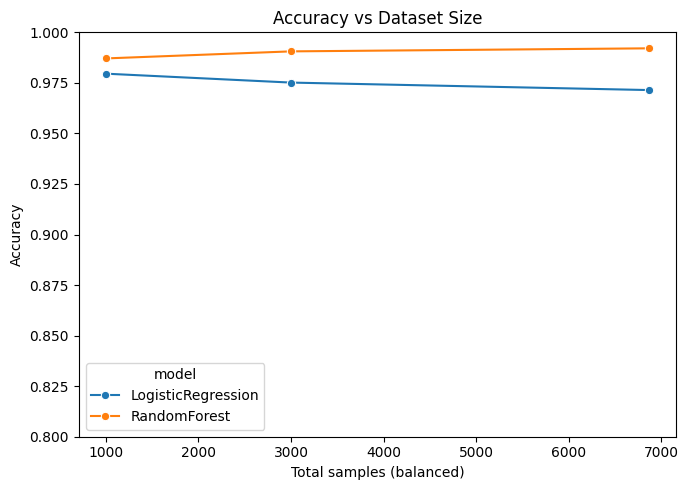

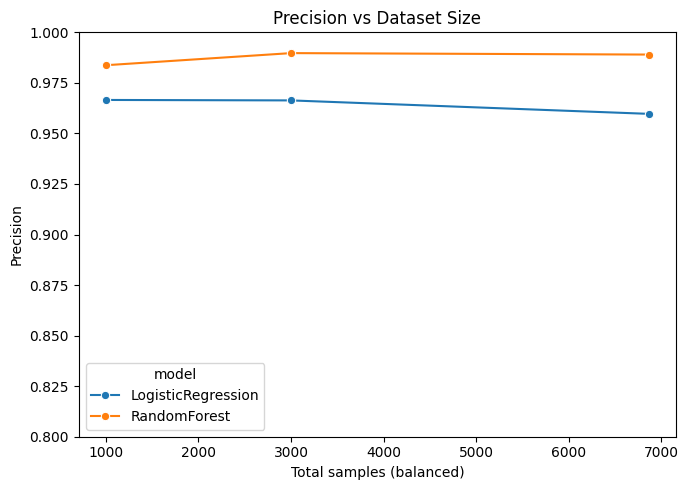

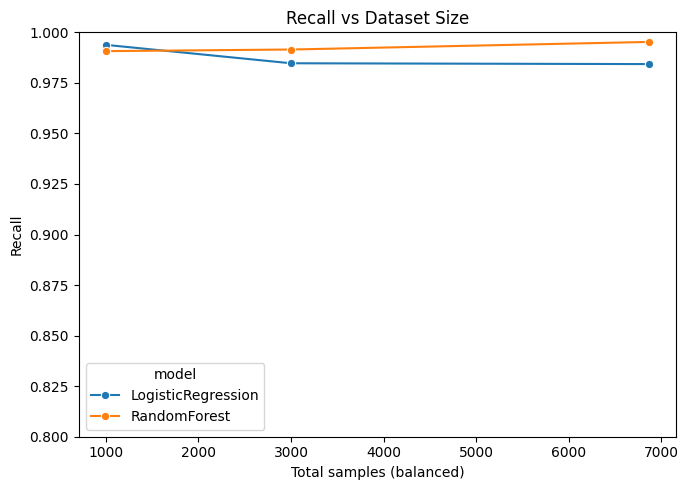

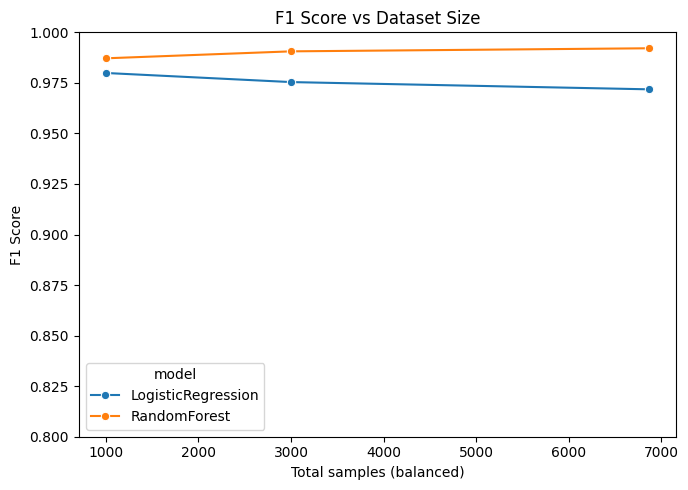

In [12]:
logreg_results = [eval_size_logreg(n) for n in sizes]
rf_results = [eval_size_rf(n) for n in sizes]

df_log = pd.DataFrame(logreg_results)
df_log["model"] = "LogisticRegression"

df_rf = pd.DataFrame(rf_results)
df_rf["model"] = "RandomForest"

df_plot = pd.concat([df_log, df_rf], ignore_index=True)

plot_dir = Path("../../Main_plots/binary_asteroids_vs_comets")
plot_dir.mkdir(parents=True, exist_ok=True)

metrics = ["acc_mean", "prec_mean", "rec_mean", "f1_mean"]
titles = {
    "acc_mean": "Accuracy",
    "prec_mean": "Precision",
    "rec_mean": "Recall",
    "f1_mean": "F1 Score",
}

for m in metrics:
    plt.figure(figsize=(7,5))
    sns.lineplot(data=df_plot, x="size", y=m, hue="model", marker="o")
    plt.title(f"{titles[m]} vs Dataset Size")
    plt.xlabel("Total samples (balanced)")
    plt.ylabel(titles[m])
    plt.ylim(0.8, 1.0)  
    plt.tight_layout()
    plt.savefig(plot_dir / f"{m}_vs_size.png", dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()